# Model Training: 
### Part 1 >>> Predictions at the beginning of the race, no data given during the race is used.

Here we see how close we can predict a race outcome with just data from the Ergast API



In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExajJ0cHhpdnV3NmhpcThscjJ6c3lmd2xvdTVibHluY3hxMDhzZ3lxdiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/SXxMF5CMWWKZUkBBgJ/giphy.gif")

### 1) Importing Packages and Data

In [13]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import F1_Modelling_Extra_Functions # Internal package here used to evaluate models
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV #cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

np.random.seed(1994)
pd.set_option('display.max_columns', None)
plt.figure(dpi=150)

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [14]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")

### 2) Data Preprocessing

In [15]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features
#   - null handling

ResultsDF=F1_Preprocessing.preprocess_F1results(ResultsDF,OneHotEncoder=True,HandleNulls=True)

In [16]:
# Group features for further analysis:
selected_features_circuit_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("circuit.circuitid_")].columns.to_list()
selected_features_constructor_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_driver_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("driverid_")].columns.to_list()
selected_features_status_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("final_status_grouped_")].columns.to_list()
selected_features_general=[col for col in ResultsDF.columns if col not in selected_features_circuit_focused+
                           selected_features_constructor_focused+selected_features_driver_focused+selected_features_status_focused]

# Not all the features in these dataframe are available before hand. 
# Below we remove features we don't know before the race starts (apart from dependent variables).
# Here we add features to each observation to have a view of what happened the races before to the same driver
features_to_add_from_the_past=['driverid',"season-round",'final_position', 'final_points','final_grid', 
                               'final_laps','race_time.millis','fastestlap.rank', 'fastestlap.lap',
                               'fastestlap.averagespeed.speed', 'fastestlap.time.in_milliseconds','race_time_millis_to_max',
                               'race_time_millis_to_min', 'race_time_millis_to_avg']

features_to_add_from_the_past+=selected_features_circuit_focused+selected_features_constructor_focused+selected_features_status_focused

print(len(features_to_add_from_the_past))

# Add certain features to see how the driver performed in previous races
ResultsDF2=F1_Preprocessing.get_past_rows(DF=ResultsDF,
                                          N=12,
                                          iterator_feature='driverid',
                                          grouper_feature='season-round',
                                          features_added=features_to_add_from_the_past)


97


In [17]:
#Features to remove (not available during the race, text, already encoded features)
features_to_remove=['driver_number', 'final_positionText', 'final_points','final_laps','driver.givenname', 'driver.familyname',
       'driver.dateofbirth', 'driver.nationality', 'constructor.url','constructor.name', 'constructor.nationality',
       'fastestlap.rank', 'fastestlap.lap', 'fastestlap.time.time','fastestlap.averagespeed.speed','racename',
       'circuit.circuitname', 'circuit.location.country', 'date','fastestlap.time.in_milliseconds',
       'season-round-driverid','race_time_millis_max_round_season','race_time_millis_min_round_season',
       'race_time_millis_avg_round_season', 'race_time_millis_to_max','race_time_millis_to_min', 'race_time_millis_to_avg']
features_to_remove=features_to_remove+selected_features_status_focused

ResultsDF2=ResultsDF2.drop(columns=features_to_remove)

#Create extra feature
ResultsDF2["final_position_is_podium"]=np.where(ResultsDF2["final_position"].isin([1,2,3]),1,0)


### 3) Check Linear Correlation

This is done to understand if there is any feature that is strong enough in terms of correlation with the dependent features : final position and race time

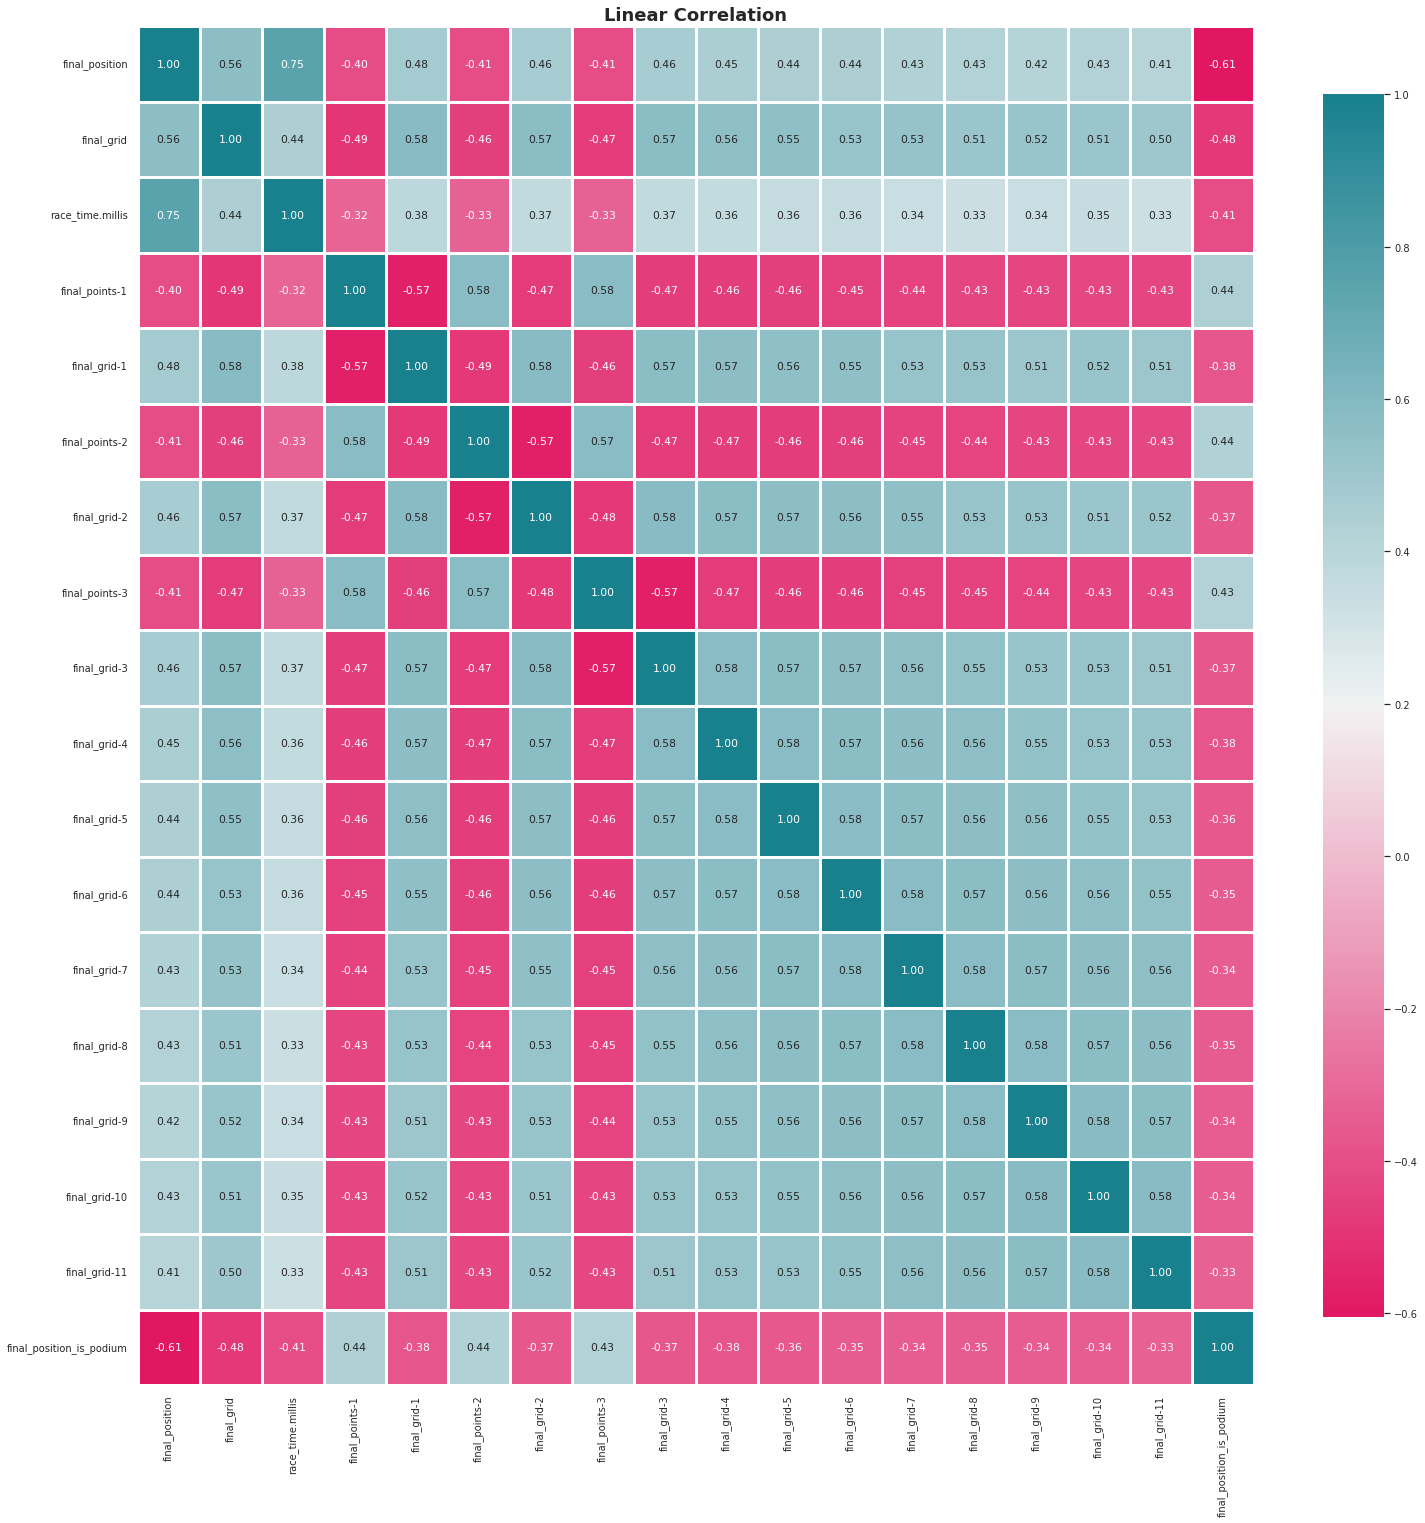

In [18]:

#Create and filter correlation df by absolute correlation value
corr_chosen=0.40
df_corr=ResultsDF2[ResultsDF2.columns].corr()
# high_corr_var=df_corr[(df_corr["race_time.millis"].abs() > corr_chosen)].index
high_corr_var=df_corr[(df_corr["final_position"].abs() > corr_chosen)].index
filtered_corr=df_corr.loc[high_corr_var,high_corr_var]

#Plot df
sns.set_theme(style="whitegrid", font_scale=0.9,font="DejaVu Sans")
fig, axs = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(filtered_corr, annot=True, fmt=".2f", linewidths=3, cmap=cmap,cbar_kws={"shrink": .9},ax=axs)
axs.set_title('Linear Correlation',fontsize=18,fontweight='bold')
plt.show()


### 4) Models

#### A. Random Forest Classifier (Predict All Final Positions)

In [29]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
TEST_SEGMENTS=[2024] 
TEST_DF=ResultsDF2[ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object']).drop(columns=["race_time.millis","final_position_is_podium"])
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object']).drop(columns=["race_time.millis","final_position_is_podium"])

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

Test DF: 354
Train Validation DF: 7277


Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=40)
Best Score:  0.12436303387334316


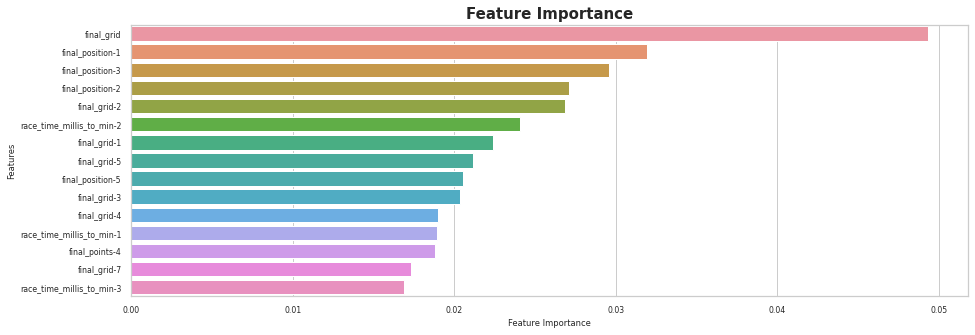

In [30]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10],
    # 'min_samples_split': [5,10,15],
    'min_samples_leaf': [10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=15,
                                                                            figuresize=(15,5))

Accuracy:  0.1553672316384181
F1 Score:  0.1298990723535248


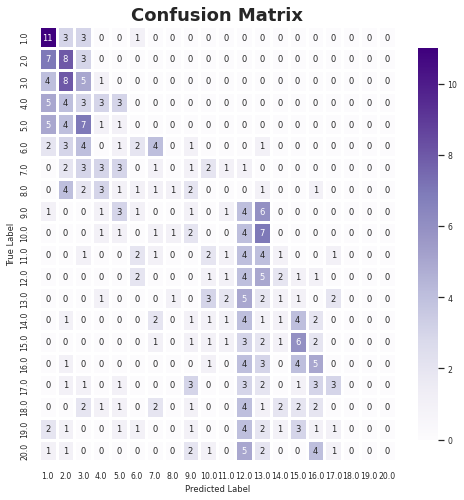

              precision    recall  f1-score   support

         1.0       0.29      0.61      0.39        18
         2.0       0.20      0.44      0.27        18
         3.0       0.15      0.28      0.19        18
         4.0       0.20      0.17      0.18        18
         5.0       0.06      0.06      0.06        18
         6.0       0.20      0.11      0.14        18
         7.0       0.08      0.06      0.07        17
         8.0       0.33      0.06      0.10        17
         9.0       0.06      0.06      0.06        18
        10.0       0.00      0.00      0.00        17
        11.0       0.12      0.06      0.08        17
        12.0       0.08      0.24      0.12        17
        13.0       0.05      0.11      0.07        18
        14.0       0.11      0.06      0.07        18
        15.0       0.27      0.33      0.30        18
        16.0       0.24      0.28      0.26        18
        17.0       0.38      0.17      0.23        18
        18.0       0.00    

c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred,figuresize=(8,8)) #confusion matrix and classification report

After tuning the hyperparameters and adjusting the amount of historical data for each driver, we found that using a Random Forest classifier with this dataset doesn’t result in strong predictions for all final race positions (based solely on previous information). However, the model shows better performance when predicting podium finishes. Below we try to predict the podium positions with the same method.

#### B. Random Forest Classifier (Predict Podium Positions)

In [32]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
TEST_DF=ResultsDF2[ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object']).drop(columns=["race_time.millis","final_position"])
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season"].isin(TEST_SEGMENTS)].select_dtypes(exclude=['object']).drop(columns=["race_time.millis","final_position"])

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position_is_podium'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

Test DF: 354
Train Validation DF: 7277


Best Estimator:  RandomForestClassifier(max_depth=10, min_samples_leaf=10)
Best Score:  0.875499792303916


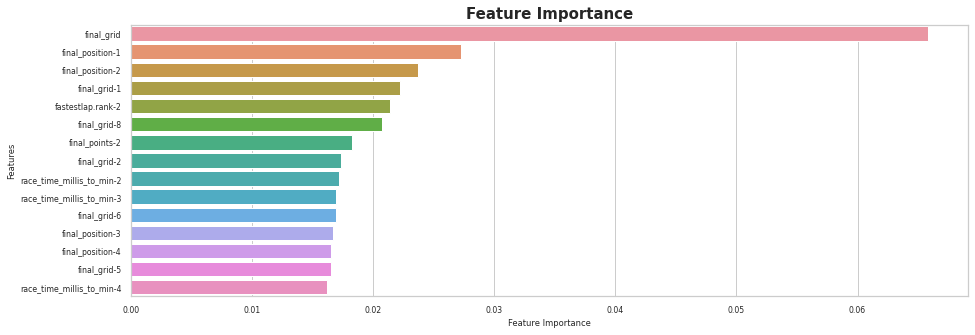

In [33]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10],
    # 'min_samples_split': [],
    'min_samples_leaf': [10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=15,
                                                                            figuresize=(15,5))

Accuracy:  0.8559322033898306
F1 Score:  0.6197156398104265


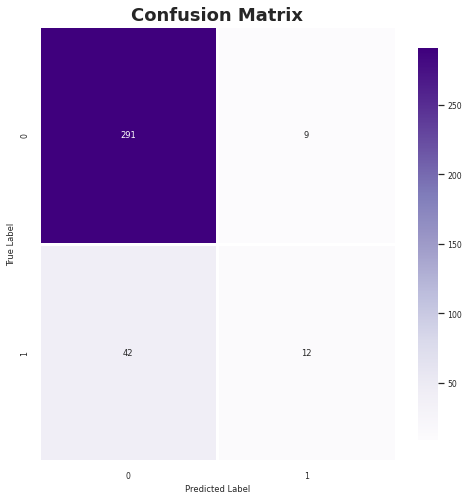

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       300
           1       0.57      0.22      0.32        54

    accuracy                           0.86       354
   macro avg       0.72      0.60      0.62       354
weighted avg       0.83      0.86      0.83       354



In [34]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred,figuresize=(8,8)) #confusion matrix and classification report

The results appear to be better; however, the metrics are misleading as the dataset is highly imbalanced when predicting podium positions. From 54 podium observations, only 12 were predicted correctly.

In [36]:
12/54

0.2222222222222222